0: will repay on time
1: will have difficulty repaying loan


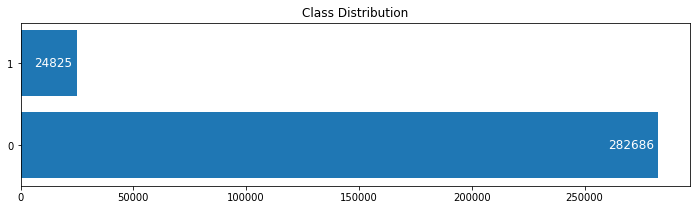

In [45]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Loading dataset
df = pd.read_csv('./application_train.csv')

# Displaying class distribution
print("0: will repay on time")
print("1: will have difficulty repaying loan")

class_dist = df['TARGET'].value_counts()

plt.figure(figsize=(12,3))
plt.title('Class Distribution')
plt.barh(class_dist.index, class_dist.values)
plt.yticks([0, 1])

for i, value in enumerate(class_dist.values):
    plt.text(value-2000, i, str(value), fontsize=12, color='white',
             horizontalalignment='right', verticalalignment='center')

plt.show()

# A function to fix age representation
def convert_age(age_days_negative):
    age_days_positive = -age_days_negative
    age_years = age_days_positive/365
    return age_years

# Applying convert_age() function to to the data frame
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(convert_age)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(convert_age)

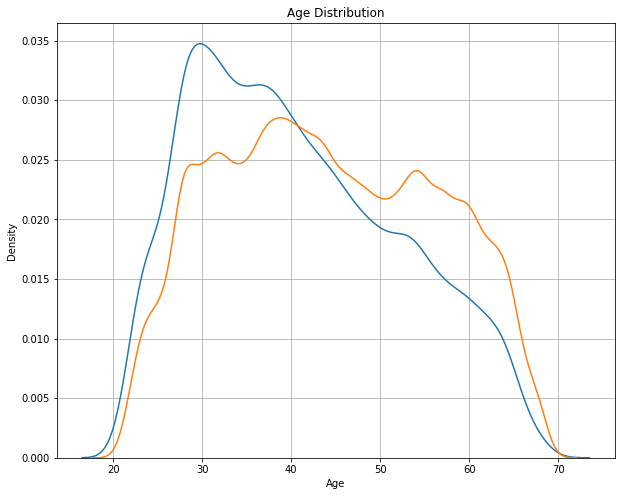

In [46]:
# Displaying age distribution using kdeplot()
plt.figure(figsize=(10,8))
plt.title('Age Distribution')
plt.xlabel('Age')
sns.kdeplot(df[df['TARGET']==1]['DAYS_BIRTH'], label='Target=1')
sns.kdeplot(df[df['TARGET']==0]['DAYS_BIRTH'], label='Target=0')
plt.grid()
plt.show()

   TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   
5       0         Cash loans           M            N               Y   
6       0         Cash loans           F            Y               Y   
7       0         Cash loans           M            Y               Y   
8       0         Cash loans           F            N               Y   
9       0    Revolving loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5         351000.0   
1             0          270000.0   1293502.5        1129500.0  

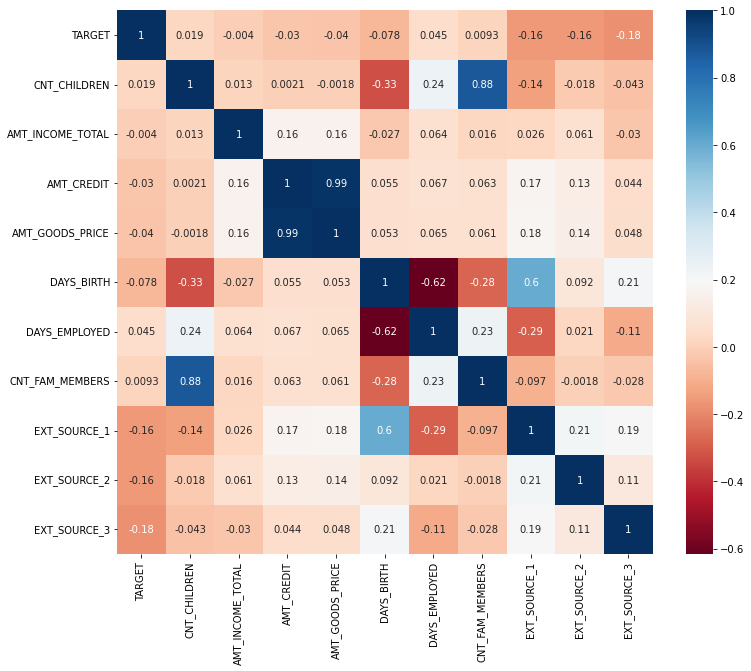

In [47]:
# Features that we are going to use to train the model
used_features = [
    'TARGET',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'CNT_FAM_MEMBERS',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

# Create a new data frame which only consists of those selected columns
reduced_df = df[used_features]

# Displaying correlation matrix based on reduced_df
plt.figure(figsize=(12,10))
sns.heatmap(reduced_df.corr(), annot=True, cmap='RdBu')

print(reduced_df.head(10))

In [48]:
# Displaying the number of unique values in each column
for column in reduced_df.columns:
    print("{}\t: {}".format(column, len(np.unique(reduced_df[column]))))
plt.show()

TARGET	: 2
NAME_CONTRACT_TYPE	: 2
CODE_GENDER	: 3
FLAG_OWN_CAR	: 2
FLAG_OWN_REALTY	: 2
CNT_CHILDREN	: 15
AMT_INCOME_TOTAL	: 2548
AMT_CREDIT	: 5603
AMT_GOODS_PRICE	: 1003
NAME_INCOME_TYPE	: 8
NAME_EDUCATION_TYPE	: 5
DAYS_BIRTH	: 17460
DAYS_EMPLOYED	: 12574
CNT_FAM_MEMBERS	: 18
EXT_SOURCE_1	: 114585
EXT_SOURCE_2	: 119832
EXT_SOURCE_3	: 815


In [49]:
# A function to convert categorical data into one-hot representation (more than 2 categories)
columns = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']

def create_one_hot(reduced_df, columns):
    for column in columns:
        reduced_df = pd.concat([reduced_df, pd.get_dummies(df[column])], axis=1, join='inner')
        reduced_df = reduced_df.drop([column], axis=1)
    
    return reduced_df

reduced_df = create_one_hot(reduced_df, columns)

print(reduced_df.head(10))

   TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       1         Cash loans            N               Y             0   
1       0         Cash loans            N               N             0   
2       0    Revolving loans            Y               Y             0   
3       0         Cash loans            N               Y             0   
4       0         Cash loans            N               Y             0   
5       0         Cash loans            N               Y             0   
6       0         Cash loans            Y               Y             1   
7       0         Cash loans            Y               Y             0   
8       0         Cash loans            N               Y             0   
9       0    Revolving loans            N               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_GOODS_PRICE  DAYS_BIRTH  DAYS_EMPLOYED  \
0          202500.0    406597.5         351000.0   25.920548       1.745205   
1          27000

[1]	training's auc: 0.720479	training's binary_logloss: 0.679178	valid_1's auc: 0.69783	valid_1's binary_logloss: 0.674474
[2]	training's auc: 0.726863	training's binary_logloss: 0.667509	valid_1's auc: 0.705693	valid_1's binary_logloss: 0.658914
[3]	training's auc: 0.729497	training's binary_logloss: 0.6578	valid_1's auc: 0.708532	valid_1's binary_logloss: 0.645947
[4]	training's auc: 0.731717	training's binary_logloss: 0.649643	valid_1's auc: 0.708705	valid_1's binary_logloss: 0.634863
[5]	training's auc: 0.732885	training's binary_logloss: 0.642788	valid_1's auc: 0.710318	valid_1's binary_logloss: 0.625778
[6]	training's auc: 0.734437	training's binary_logloss: 0.636808	valid_1's auc: 0.712524	valid_1's binary_logloss: 0.618681
[7]	training's auc: 0.735883	training's binary_logloss: 0.631579	valid_1's auc: 0.71562	valid_1's binary_logloss: 0.61343
[8]	training's auc: 0.73741	training's binary_logloss: 0.627105	valid_1's auc: 0.718111	valid_1's binary_logloss: 0.608766
[9]	training's

[71]	training's auc: 0.773268	training's binary_logloss: 0.570991	valid_1's auc: 0.732593	valid_1's binary_logloss: 0.53199
[72]	training's auc: 0.773557	training's binary_logloss: 0.570664	valid_1's auc: 0.732507	valid_1's binary_logloss: 0.530093
[73]	training's auc: 0.773924	training's binary_logloss: 0.570341	valid_1's auc: 0.732002	valid_1's binary_logloss: 0.529465
[74]	training's auc: 0.774178	training's binary_logloss: 0.570058	valid_1's auc: 0.732026	valid_1's binary_logloss: 0.529118
[75]	training's auc: 0.77437	training's binary_logloss: 0.569854	valid_1's auc: 0.732032	valid_1's binary_logloss: 0.52913
[76]	training's auc: 0.774706	training's binary_logloss: 0.569522	valid_1's auc: 0.731825	valid_1's binary_logloss: 0.524398
[77]	training's auc: 0.774888	training's binary_logloss: 0.569333	valid_1's auc: 0.731738	valid_1's binary_logloss: 0.52431
[78]	training's auc: 0.775098	training's binary_logloss: 0.569064	valid_1's auc: 0.731821	valid_1's binary_logloss: 0.524082
[79]

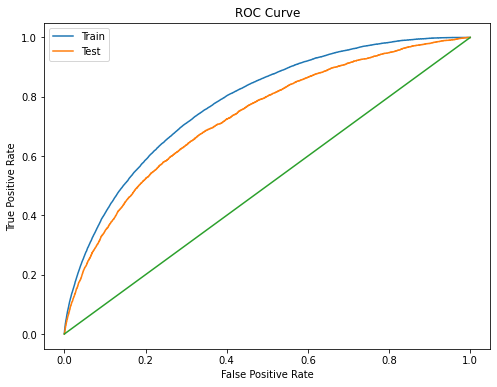

In [50]:
# Using label encoder to encode columns which consists of only 2 categories
le_name_contract_type = LabelEncoder()
reduced_df['NAME_CONTRACT_TYPE'] = le_name_contract_type.fit_transform(reduced_df['NAME_CONTRACT_TYPE'])

le_flag_own_car = LabelEncoder()
reduced_df['FLAG_OWN_CAR'] = le_flag_own_car.fit_transform(reduced_df['FLAG_OWN_CAR'])

le_flag_own_realty = LabelEncoder()
reduced_df['FLAG_OWN_REALTY'] = le_flag_own_realty.fit_transform(reduced_df['FLAG_OWN_REALTY'])

# Filling missing values with the mean of the corresponding column
reduced_df.loc[:,'AMT_GOODS_PRICE'] = reduced_df['AMT_GOODS_PRICE'].fillna(reduced_df['AMT_GOODS_PRICE'].mean())
reduced_df.loc[:,'CNT_FAM_MEMBERS'] = reduced_df['CNT_FAM_MEMBERS'].fillna(reduced_df['CNT_FAM_MEMBERS'].mean())
reduced_df.loc[:,'EXT_SOURCE_1'] = reduced_df['EXT_SOURCE_1'].fillna(reduced_df['EXT_SOURCE_1'].mean())
reduced_df.loc[:,'EXT_SOURCE_2'] = reduced_df['EXT_SOURCE_2'].fillna(reduced_df['EXT_SOURCE_2'].mean())
reduced_df.loc[:,'EXT_SOURCE_3'] = reduced_df['EXT_SOURCE_3'].fillna(reduced_df['EXT_SOURCE_3'].mean())

# Split the data into train/test
X = reduced_df.iloc[:,1:].values
y = reduced_df['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Value normalization
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

# Initializing LightGBM classifier
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)

# Training the LightGBM model
model.fit(X_train_scaled, y_train, eval_metric='auc', 
          eval_set=[(X_train_scaled, y_train),(X_test_scaled, y_test)])


# Predict the probability score
prob_train = model.predict_proba(X_train_scaled)
prob_test = model.predict_proba(X_test_scaled)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, prob_train[:,1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test, prob_test[:,1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

# Plot the ROC graph
plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Calculating the train and test AUC score
auc_score_train = roc_auc_score(y_train, prob_train[:,1])
auc_score_test = roc_auc_score(y_test, prob_test[:,1])

print(auc_score_train)
print(auc_score_test)

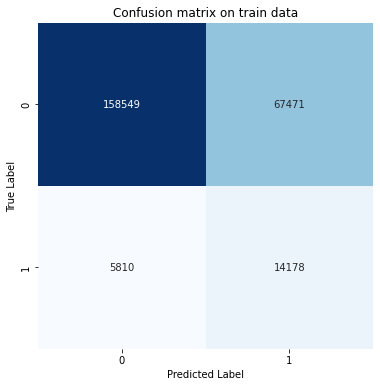

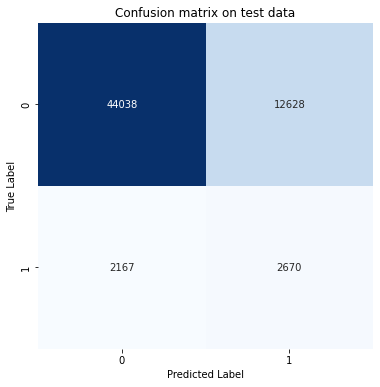

In [51]:
#### THE CODE BELOW IS NOT EXPLAINED IN THE MEDIUM ARTICLE
# Predict train and test data
pred_train = model.predict(X_train_scaled)
pred_test = model.predict(X_test_scaled)

# Constructing the confusion matrix based on train data
cm_train = confusion_matrix(y_train, pred_train)

# Display the train confusion matrix
plt.figure(figsize=(6,6))
plt.title('Confusion matrix on train data')
sns.heatmap(cm_train, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Constructing the confusion matrix based on test data
cm_test = confusion_matrix(y_test, pred_test)

# Display the test confusion matrix
plt.figure(figsize=(6,6))
plt.title('Confusion matrix on test data')
sns.heatmap(cm_test, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()